## Factors that Contribute to the Success of a Broadway Show

So much money goes into investing in and creating a Broadway show that a failure means a huge loss both financially and professionally. Therefore I would like to determine the factors that lead to a successful Broadway production as it will be useful to both producers and consumers of theatrical entertainment.

I know my own preferences, but I want to be able to quantify the preferences of the average Broadway consumer.  While thinking about the aspects that I typically look at when choosing a Broadway show and the statistics available on IBDB:


I will be scraping the following variables from IMBD.com:

 - The average gross revenue per show over the 2018/2019 season 
 - The average attendance per show over the 2018/2019 season
 - The average capacity per show over the 2018/2019 season
 - The average gross potential per show over the 2018/2019 season
 
I will manually add:
 - The type of show (revival or original)
 - Number of Tony Awards
 

I will be using the average gross revenue divided by the average attendance as independent variable (my measure of success). I will then regress factors such as category of the show (i.e. revival or original), average capacity per show, gross potential, and number of tony awards.

See all my work below!
![alt text](https://media.giphy.com/media/oqyKi6VA1du8M/giphy.gif)


## Webscraped Data
1. First I pulled a list of URLs from the IBDB's 2018-19 Season Page
2. I then cleaned up the list of urls of just the production pages, showing the statistics table
3. I removed a problem url (Angels in Perestroika)
4. I looped through the list of URLs to pull the data from the Statistics Tables on each page
5. When inspecting the contents, I could see that the statistics data was defined inside a javascript variable (springsteen_soup.find_all("script")[4]). 
6. After researching, and asking Stack Overflow,  I determined that Regex was the best solution
7. Python regex would be able to extract the data within the script tag, then extract a group from that regex.
8. I then had to use ast.literal_eval to parse a data string because the string didn't match JSON format. Otherwise, I would not be able to parse it.

In [1]:
import requests 
import numpy as np
import pandas as pd
import pprint
import ast
from bs4 import BeautifulSoup 
import re
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
sns.set_theme(style="ticks", color_codes=True)
#importing the necessary packages

ibdbS1_url = 'https://www.ibdb.com/season/1288' #Assigning variable to IBDB's 2018-19 Season Page
ibdbS1_response = requests.get(ibdbS1_url) #Using requests to retrieve data from a given URL
ibdbS1_soup = BeautifulSoup(ibdbS1_response.text, 'html.parser')#Parsing the whole HTML page using BeautifulSoup

path = "/Users/galenhaggerty/Documents/GitHub/final-project-galenhaggerty/"

In [2]:
links = [link.get('href') for link in ibdbS1_soup.find_all('a')]# Finding all links within the 2018-19 season page
ibdbS1_links = set([''.join([ibdbS1_url, link]) for link in links if link]) #Adding homepage and keeping the unique links

In [3]:
productions = [] # I am creating a new list
for link in ibdbS1_links: #for each url in the ibdbS1 links list
    if 'production' in link: #if "production" is included in the url
        productions.append(link) #append those urls to my new productions list
        
#removing a problem url:
productions2 = [] # I am creating a new list
for link in productions: #for each url in the ibdbS1 links list
    if 'perestroika' not in link: #if "perestroika" is not in the url 
        productions2.append(link) # add to my new list

In [4]:
string = '#statistics' # I am assigning the string "#statistics" to a variable
prod_list=[i + string for i in productions2] #I am adding this string to the end of each url to create a list of the shows' stats pages urls

In [5]:
finalprod_list = [i.replace('/season/1288', '') for i in prod_list] #I am removing a portion of each url to get the correct list of pages to scrape

In [6]:
#This code is to scrape the "statistics table" for each show:
out = [] #creating an empty list
for i in finalprod_list: #looping through my list of urls
    springsteen_response = requests.get(str(i))
     #parsing the html using beautifulsoup:
    springsteen_soup = BeautifulSoup(springsteen_response.content, 'html.parser')

    # Find a <script> tag that has "grossdata" text inside
    # This is pulling the entire "statistics" table section of each show page
    scriptdata = springsteen_soup.find("script", text=re.compile("grossdata")).string 
    
    #since the table section is in java, 
    #the following code reads the java and pulls it out the way we want
   
    grossdata_pattern = re.compile(r"grossdata ?= ?({.+});?") 
    # this is a regular expression
    # ? after space means that space may or may not occur in string
    # . (dot) means we are matching any character
    # + sign when used with previous dot means that any character needs to occur at least one time
    # at the end ";" may or may not occur
    grossdata_search = grossdata_pattern.search(scriptdata)

    if grossdata_search:
        # Extracting a second group (first is the whole string from "grossdata" to ";")
        # the second group is between parentheses "()"
        grossdata = grossdata_search.group(1)
        
   #ast.literal_eval raises an exception if the input isn't a valid Python datatype,
   #so the code won't be executed if it's not.
    grossdata = ast.literal_eval(grossdata)

    grossdata_2018 = grossdata[0]

    df = pd.DataFrame(grossdata_2018)
    # Remove unwanted columns
    df.drop([5, 6, 7, 8, 9, 10, 11], axis=1, inplace=True)
    df.columns = ['Week Ending', 'Gross', '% Gross Pot.', 'Attendance', '% Capacity']
    df['url'] = str(i)
    out.append(df) #append the data to the empty list
all_data =pd.concat(out)   #create a dataframe

## Cleaning the Data
1. I selected the columns I wanted to clean up in order to be able to groupby
2. I changed those columns to string format and removed the characters causing issues
3. I changed the columns to float in order to avearge the rows per show and create a new column "Average Price" by dividing Gross/Attendance
4. I then imported my manual csv with the show titles and category (original or revival)
5. I decided to import the data manually after running into some issues trying to use selenium to webscrape the titles and tags on the show pages.

In [7]:
col = ['Gross', '% Gross Pot.', 'Attendance', '% Capacity']# putting the columns I want to convert and clean up in a list 
all_data[col] = all_data[col].astype(str)  # cast the columns to string

all_data[col] = all_data[col].replace({'\$': '', ',': '', '%': ''}, regex=True) #replace the characters I want to remove

all_data[col] = all_data[col].astype(float)  # cast to float

drop_week = all_data.drop(columns=['Week Ending']) # removing the week by column
show_data = drop_week.groupby('url').mean() #getting the average of each column, gouping by the show url

show_data['Av. Price'] = show_data['Gross']/show_data['Attendance'] #creating new column with the new variable "average price"
#this is the average gross/ attendance as each show ran for different lengths.
bway_data = show_data.round(2)

In [8]:
bway_manual_data = pd.read_csv(path+ "bway_manual_data.csv") #importing my manual csv file with additional data
merged_data = pd.merge(bway_manual_data, bway_data, left_on=['url'],right_on=['url'],how='left') #merging both files on the url column
final_data = merged_data.drop(['url'], axis = 1) #dropping the lengthy url column

In [9]:
final_data #this is the final data set!

,Title,Original/Revival,Tonys,Gross,% Gross Pot.,Attendance,% Capacity,Av. Price
0,A Bronx Tale The Musical,Original,0,614142.30,66.60,7098.00,85.20,86.52
1,Aint Too Proud,Original,1,1452345.78,96.17,10895.39,95.61,133.30
2,All My Sons,Revival,0,518748.40,60.00,5433.80,91.80,95.47
3,American Son,Original,0,577131.47,68.88,4966.82,84.35,116.20
4,Anastasia,Original,0,752045.52,68.61,7939.57,86.82,94.72
5,Angels In America Millennium Approaches,Revival,3,1023514.14,77.00,8996.57,92.43,113.77
6,Be More Chill,Original,0,482847.73,55.18,5528.36,77.64,87.34
7,Beetlejuice,Original,0,1098203.49,82.63,11103.49,92.93,98.91
8,Bernhardt Hamlet,Original,0,323852.92,56.42,4561.83,84.25,70.99
9,Burn This,Revival,0,706037.86,69.14,6569.14,85.57,107.48


In [10]:
final_data.to_csv(path + 'finaldata.csv') #exporting the csv

## Graphs

![alt text](https://media.giphy.com/media/LedVYzRx24nkI/giphy-downsized-large.gif)

1. I created a scatterplot of the show with av. price on the X axis and the gross potential on the y axis
2. I also color coded by the show type (original vs. revival)
3. My Prediction was that the graph would show a linear correlation between the av. price (higher demand) and the gross potential, meaning that the higher demand for the show results in shows reaching their gross potential.
4. I decided on removing the Springsteen show as it was an outlier with ticket prices way higher than normal due to his fanbase and limited run.
5. I created a line plot of each type (original and revival) and then plotted them by the Av. Price and %capacity
6. I then once again dropped my outlier and created a box plot of the effect of Tony awards on the av ticket price

<ipython-input-11-81cfc3cd8d53>:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "Transparent" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(path+'bwaydemand.png', dpi = 300, Transparent=True)


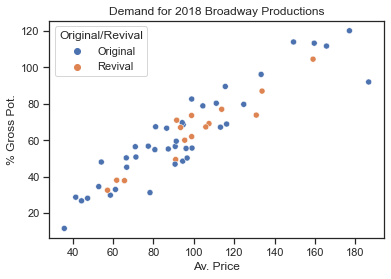

In [11]:
sns.scatterplot(data=final_data.drop([34]), x="Av. Price", y="% Gross Pot.", hue="Original/Revival").set(title='Demand for 2018 Broadway Productions')
plt.savefig(path+'bwaydemand.png', dpi = 300, Transparent=True) #exporting a transparent png of the graph

The above graph confirms my prediction that the higher "demand" of the show (my new variable of average price: Gross/Attendance), results in a higher probability of reaching the gross potential. This is not surprising, however I wanted to highlight the Original shows vs. Revivals to see if there would be a larger demand for one over the other. Based on this graph it appears that the tyoe of show does not make much of a difference on the demand.

<ipython-input-13-d9624bfab9d7>:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "Transparent" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(path+'capacitydemand.png', dpi = 300, Transparent=True) #exporting a transparent png of the graph


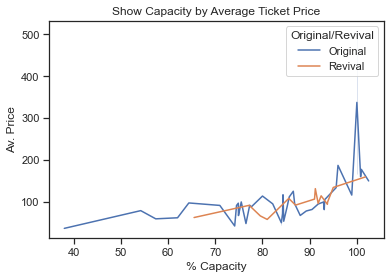

In [13]:
sns.lineplot(data=final_data, x="% Capacity", y="Av. Price", hue="Original/Revival").set(title='Show Capacity by Average Ticket Price')
plt.savefig(path+'capacitydemand.png', dpi = 300, Transparent=True) #exporting a transparent png of the graph

I was hoping to get a clearer picture of whether the type of show has any impact on a show's success by plotting the Av. Price and capacity. The graph shows that there is a clear correlation between shows reaching 100% capacity and the with the average price per ticket(my demand variable). However it's still not clear whether a Revival or Original show determines the demand. What is interesting though, is that none of the Revivals dip below 60% capacity whereas Originals go as low as less than 40% capacity.

<ipython-input-12-0345295de15e>:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "Transparent" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(path+'tonydemand.png', dpi = 300, Transparent=True)


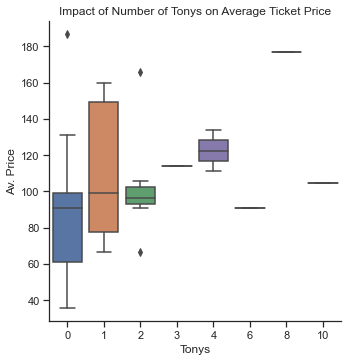

In [12]:
sns.catplot(data=final_data.drop([34]), kind="box", x="Tonys", y="Av. Price").set(title='Impact of Number of Tonys on Average Ticket Price')
plt.savefig(path+'tonydemand.png', dpi = 300, Transparent=True)  #exporting a transparent png of the graph

Unfortunately the above graph does not confirm my prediction that the more Tony Awards a show has will increase demand and therefore the average ticket price of a show. It does appear to show a positive increase in the av. ticket price up to 4 Tony Awards, but becomes unpredictable after that. I would need a much larger data set to say with any certainty that Tony awards increase overall demand.

### My Model and Regressions

Model: Gross Potential Revenue (%)
   - GP = b0 + b1AvPrice + b2Capacity + b3Category + b4Tony

Independent Variables:
   - Average Ticket Price (Average Gross/Average Attendance)
   - Average Capacity (%)
   - Total Tony Awards
   - Original or Revival (Original = 0, Revival =1)
   
Results (From R Markdown File)
   - 3 variables were significant. Av. Price and Capactity at the 99% significance level and Number of Tonys at the        95% significance level
   - The average price of a ticket increasing by 1 dollar will increase gross potential by .12 percentage points (so        if the average price of a ticket goes up by 10 dollars, you will see about a 1.2 percentage point increase            towards gross potential revenue)
   - Unsurprisingly, a 1% increase in seats filled (capacity) will result in about a 1.2 percentage points.
   - Winning 1 extra Tony award will increase the gross potential of a show by about 1.87 percentage points.

